In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
tom99763_testtt_path = kagglehub.dataset_download('tom99763/testtt')

print('Data source import complete.')


100%|██████████| 124M/124M [00:02<00:00, 46.1MB/s]

Extracting files...


Data source import complete.


In [1]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.amp import autocast, GradScaler

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

In [3]:
root_dir = '/content/kdef_cropped'
classes = {
    label_idx: class_name \
        for label_idx, class_name in enumerate(
            sorted(os.listdir(root_dir))
        )
}

img_paths = []
labels = []
for label_idx, class_name in classes.items():
    class_dir = os.path.join(root_dir, class_name)
    for img_filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_filename)
        img_paths.append(img_path)
        labels.append(label_idx)

In [4]:
classes

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [5]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

In [6]:
class Dataset(Dataset):
    def __init__(
        self,
        X, y,
        transform=None
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, self.labels[idx]

In [8]:
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)
    img = torch.tensor(img).permute(2, 0, 1).float()
    normalized_img = img / 255.0
    return normalized_img

In [9]:
train_dataset = Dataset(
    X_train, y_train,
    transform=transform
)
val_dataset = Dataset(
    X_val, y_val,
    transform=transform
)
test_dataset = Dataset(
    X_test, y_test,
    transform=transform
)

In [10]:
train_batch_size = 16
test_batch_size = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16])


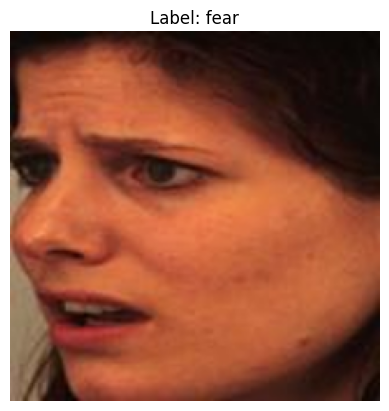

In [11]:
train_features, train_labels = next(iter(train_loader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[0].permute(1, 2, 0)
label = train_labels[0].item()
plt.imshow(img)
plt.axis('off')
plt.title(f'Label: {classes[label]}')
plt.show()

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.block(x)

In [13]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(
        in_channels, out_channels,
        kernel_size=3, stride=stride, padding=1
    )
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(
        out_channels, out_channels,
        kernel_size=3, stride=1, padding=1
    )
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.downsample = nn.Sequential()
    if stride != 1 or in_channels != out_channels:
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
            nn.BatchNorm2d(out_channels)
            )
    self.relu = nn.ReLU()

  def forward(self, x):
    shortcut = x.clone()
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x += self.downsample(shortcut)
    x = self.relu(x)
    return x

In [14]:
class ResNet(nn.Module):
  def __init__(self, n_classes):
      super().__init__()
      self.model = nn.Sequential(
          ConvBlock(3, 64),
          ConvBlock(64, 64),
          ResidualBlock(64, 64),
          ResidualBlock(64, 64),

          ConvBlock(64, 128),
          ConvBlock(128, 128),
          ResidualBlock(128, 128),
          ResidualBlock(128, 128),

          ConvBlock(128, 256),
          ConvBlock(256, 256),
          ResidualBlock(256, 256),
          ResidualBlock(256, 256),

          nn.AdaptiveAvgPool2d((1, 1)),
      )
      self.fc = nn.Linear(256, n_classes)

  def forward(self, x):
      x = self.model(x)
      x = torch.flatten(x, 1)
      return self.fc(x)


In [15]:
n_classes = len(list(classes.keys()))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ResNet(n_classes).to(device)

In [16]:
model.eval()

dummy_tensor = torch.randn(1, 3, 224, 224).to(device)

with torch.no_grad():
    output = model(dummy_tensor)

print('Output shape:', output.shape)

Output shape: torch.Size([1, 7])


In [17]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [19]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs,
    accumulation_steps=32
):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    scaler = GradScaler()

    for epoch in range(epochs):
        batch_train_losses = []
        model.train()

        optimizer.zero_grad()

        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            with autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss = loss / accumulation_steps

            scaler.scale(loss).backward()

            if (idx + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            batch_train_losses.append(loss.item())

            del inputs, labels, outputs
            torch.cuda.empty_cache()

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), '/content/best_model.pth')
            print(f"Best model saved with validation loss: {best_val_loss:.4f}")

        print(f'EPOCH {epoch + 1}: Train loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')
        torch.cuda.empty_cache()

    return train_losses, val_losses


In [20]:
lr = 1e-1
epochs = 15

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr
)

In [21]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

Best model saved with validation loss: 1.9469
EPOCH 1: Train loss: 0.0649	Val loss: 1.9469
Best model saved with validation loss: 1.9267
EPOCH 2: Train loss: 0.0603	Val loss: 1.9267
EPOCH 3: Train loss: 0.0589	Val loss: 2.4175
Best model saved with validation loss: 1.9031
EPOCH 4: Train loss: 0.0593	Val loss: 1.9031
EPOCH 5: Train loss: 0.0584	Val loss: 5.4177
EPOCH 6: Train loss: 0.0592	Val loss: 12.8670
EPOCH 7: Train loss: 0.0601	Val loss: 1.9921
Best model saved with validation loss: 1.8994
EPOCH 8: Train loss: 0.0582	Val loss: 1.8994
EPOCH 9: Train loss: 0.0583	Val loss: 5.4391
EPOCH 10: Train loss: 0.0575	Val loss: 2.2011
Best model saved with validation loss: 1.8010
EPOCH 11: Train loss: 0.0539	Val loss: 1.8010
EPOCH 12: Train loss: 0.0558	Val loss: 1.9750
EPOCH 13: Train loss: 0.0545	Val loss: 112.3861
EPOCH 14: Train loss: 0.0624	Val loss: 62.6231
EPOCH 15: Train loss: 0.0569	Val loss: 6.0831


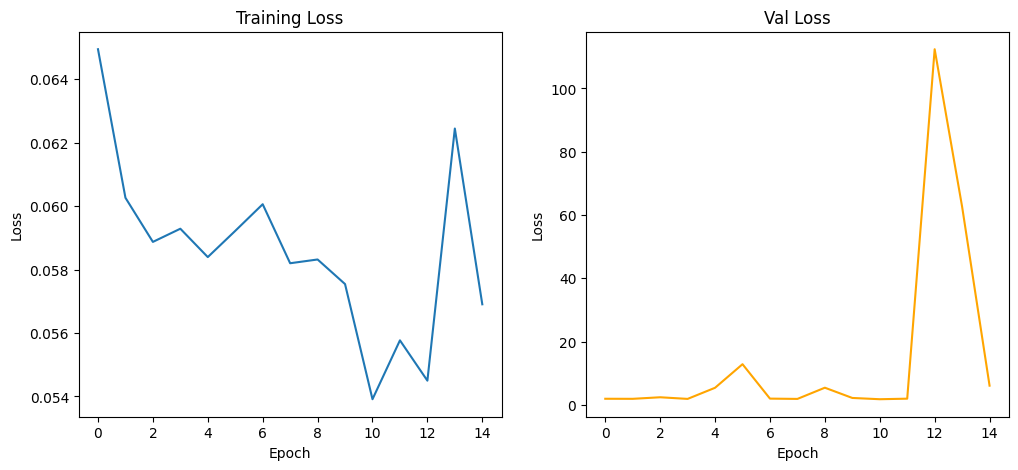

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

In [23]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.11945392491467577
Test accuracy:  0.16382252559726962
